## shapemetrics: grid with multipolygons and rings


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math, random, time, os, sys, string

#geometry
import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
import mp_helper_tool_rodrigo
import helper_tool_rodrigo

In [2]:
shp_path = '/Users/rodrigo/Documents/tfg/data/ups/potential_footprints.shp'
shpfile = gpd.read_file(shp_path)
print(shpfile.crs)
shpfile.head()

{'init': 'epsg:3395'}


,id,geometry
0,22,"POLYGON ((7841750.161 4069156.139, 7843348.401..."
1,23,"POLYGON ((7841430.514 4070115.083, 7843668.048..."
2,24,"POLYGON ((7841110.866 4071074.026, 7843987.696..."
3,25,"POLYGON ((7841909.985 4072192.793, 7843188.577..."
4,26,"POLYGON ((7841270.690 4073151.737, 7843827.872..."


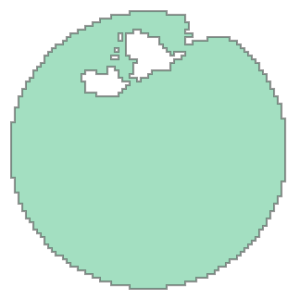

In [80]:
pf = shpfile['geometry'][0]
display(pf)

In [ ]:
for i in range(shpfile.shape[0]):
    pf = shpfile['geometry'][i]
    display(pf)
    
    vertexLst1, featPntLst1 = mp_helper_tool_rodrigo.ConvertToGridPnts(pf)
    vertexLst, featPntLst = ConvertToGridPnts(pf)
    
    # plot all together
    
    together = []
    for i in range(len(featPntLst1)):
        together +=  featPntLst1[i]
    
    xs = [x[0] for x in together]
    ys = [x[1] for x in together]
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')
    plt.scatter(xs, ys, s = 2)
    plt.show()

    together = []
    for i in range(len(featPntLst)):
        together +=  featPntLst[i]
    
    xs = [x[0] for x in together]
    ys = [x[1] for x in together]
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')
    plt.scatter(xs, ys, s = 2)
    plt.show()
        

## Dispersion index


In [18]:
start = time.time()
dispersion = mp_helper_tool_rodrigo.interpointDistance(featPntLst[0])
end = time.time()
print(end - start)

11.063657283782959


In [20]:
A = pf.area
r = (A / math.pi)**.5       # radius of equal area circle (circle with area equal to shape area)
circ_interD = r * .9054

# cohesion index is ratio of avg interpoint distance of circle to
# avg interpoint distance of shape...
CohesionIndex = circ_interD / dispersion
CohesionIndex

0.9779766265854133

## fix the grid function

In [21]:
# https://stackoverflow.com/questions/32275933/python-return-y-coordinates-of-polygon-path-given-x
import shapely.geometry as sg
def polygon_intersect_x(poly, x_val):
    """
    Find the intersection points of a vertical line at
    x=`x_val` with the Polygon `poly`.
    """
    if x_val < poly.bounds[0] or x_val > poly.bounds[2]:
        raise ValueError('`x_val` is outside the limits of the Polygon.')
    if isinstance(poly, sg.Polygon):
        poly = poly.boundary
    vert_line = sg.LineString([[x_val, poly.bounds[1]],
                               [x_val, poly.bounds[3]]])
    pts = [pt.xy[1][0] for pt in poly.intersection(vert_line)]
    pts.sort()
    return pts

def polygon_intersect_y(poly, y_val):
    """
    Find the intersection points of a horizontal line at
    y =`y_val` with the Polygon `poly`.
    """
    #if y_val < poly.bounds[1] or y_val > poly.bounds[3]:
    #    raise ValueError('`y_val` is outside the limits of the Polygon.')
    
    if isinstance(poly, sg.Polygon):
        poly = poly.boundary
        horiz_line = sg.LineString([[poly.bounds[0], y_val],
                                    [poly.bounds[2], y_val]])
    
    pts = [pt.xy[0][0] for pt in poly.intersection(horiz_line)]
    pts.sort()
    pts = list(zip(pts, pts[1:]))    
    return pts

In [22]:
def ConvertToGridPnts(ShpGeom_mp):


    mp_pntLst = []
    mp_featPntLst = []

    try:
        npols = len(ShpGeom_mp)
    except TypeError:
        print('Not a multipolygon')
        npols = 1

    print('number of polygons:' , npols)
    for i in range(npols):

        try:
            ShpGeom = ShpGeom_mp[i]
        except:
            ShpGeom = ShpGeom_mp
        # Get shape extent and extract bounding coordinates...
        extent = ShpGeom.bounds

        #---------------------------
        # LIST OF COORDINATES OF FEATURE VERTICES (for single part features)...
        pntLst = []   # stores feature array...
        subVLst = []

        ExteriorCoords = iter(ShpGeom.exterior.coords)    # get first polygon if we have a multipolygon

        pnt = next(ExteriorCoords)  # get point from array
        # for each part array...
        while pnt:

            # get point XY
            X, Y = pnt[0], pnt[1]
            subVLst.append([X,Y])  # add XY to list

            try:
                pnt = next(ExteriorCoords)  # get next point
            except StopIteration:
                break


        pntLst.append(subVLst)
        mp_pntLst.append(pntLst)
        subVLst = []

        #----------------------------------
        # GRID OF POINTS

        featPntLst = []   # list of coordinates of points in feature

        # feature area...
        a = ShpGeom.area

        # desired shape area in pixels...
        numPix = 10000

        # calculate pixel size...
        cellsize = (a / numPix)**.5

        # get min and max XY values
        minX, minY, maxX, maxY = extent[0], extent[1], extent[2], extent[3]

        # offset grid by half a pixel...
        minX -= cellsize / 2
        maxY += cellsize / 2

        # set current Y to maxY...
        Y = maxY

        # for each row...
        while Y >= minY:

            # get range of X values within which lie the inside of feature...
            rangeLst = polygon_intersect_y(ShpGeom_mp,Y)
            #print(rangeLst)
            #print('rangeLst:', rangeLst)

            # set X to leftmost column...
            X = minX

            # for each column..
            while X <= maxX:

                # for each range of X values...
                for x1,x2 in rangeLst:

                    # if current X is within range, point is in shape...
                    if x1 <= X <= x2:
                        featPntLst.append([X,Y])   # at point to feature point list
                        break

                # X coordinate of next column
                X += cellsize

            # Y coordinate for next row...
            Y -= cellsize


        # remove points inside holes
        print('number of rings in polygon', i + 1, ':', len(ShpGeom.interiors))

        
        if len(ShpGeom.interiors) > 0:

            removeids = []
            for i in range(len(featPntLst)):
                SInsidePnt = Point(featPntLst[i])

                for Interior in ShpGeom.interiors:
                    PInterior = Polygon(Interior)

                    if PInterior.contains(SInsidePnt):
                        removeids.append(i)

            featPntLst = [v for i, v in enumerate(featPntLst) if i not in removeids]
            print("\npoints removed:", len(removeids))
        
        mp_featPntLst.append(featPntLst)

    # return feature XY list...
    return mp_pntLst, mp_featPntLst


In [122]:

def interpointDistance(ptList): # requires list of XY coordinates of points in shape

    # number of points in shape...
    numPts = len(ptList)

    samplSize = 10    # number of points in sample
    samples = 30        # number of samples

    avgD = 0    # average interpoint distance

    # run specified number of samples...
    for t in range(samples):

        total_D = 0     # cumulative distance
        cnt = 0         # number of calculations

        # select a random sample of shape points...
        rng = np.random.default_rng()
        sampLst = ng.choice(featPntLst[0], samplSize)

        #sampLst = random.sample(ptList, samplSize)
        #print(len(sampLst))

        # for each point in sample, calculate distance between it and
        # every other point...
        for pt1 in sampLst:

            # get coordinates of a point...
            X1 = pt1[0]
            Y1 = pt1[1]

            # calculate distance to all other points in sample...
            for pt2 in sampLst:

                # skip pt2 if it is the same as pt1...
                if (pt1 == pt2).all(): continue

                # get coord. of point from sample...
                X2 = pt2[0]
                Y2 = pt2[1]

                # calculate distance to pt1...
                dist = ((X1-X2)**2 + (Y1-Y2)**2)**.5

                # cumulative interpoint distance...
                total_D += dist

                # number of calculations...
                cnt += 1

        # average interpoint distance...
        avgD += (total_D / cnt) / samples

    return avgD


In [123]:
vertexLst, featPntLst = ConvertToGridPnts(pf)

Not a multipolygon
number of polygons: 1
number of rings in polygon 1 : 5

points removed: 465


In [124]:
interpointDistance(np.array(featPntLst[0]))

5212.369667025637

In [97]:
sampLst = random.sample(featPntLst[0], 100)

In [99]:
featnp = np.array(featPntLst)

In [118]:
rng = np.random.default_rng()
rng.choice(featPntLst[0], 2)

array([[7842147.43887382, 4063232.41088291],
       [7841735.35343759, 4061893.13321516]])

In [128]:
(np.array(featPntLst[0])).shape

(9997, 2)

In [33]:
# Example
p = sg.Polygon([(0, 0),
                (10, 0),
                (30, 10),
                (70, -50),
                (80, 30),
                (40, 40),
                (60, 80),
                (50, 100),
                (15, 20),
                (0, 0)])
y_val = 45
points = polygon_intersect_y(p, y_val)
points


[(25.9375, 42.5)]

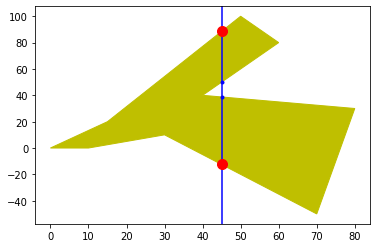

In [6]:
# Example
p = sg.Polygon([(0, 0),
                (10, 0),
                (30, 10),
                (70, -50),
                (80, 30),
                (40, 40),
                (60, 80),
                (50, 100),
                (15, 20),
                (0, 0)])
x_val = 45
points = polygon_intersect_x(p, x_val)
minmax = [points[0], points[-1]]  # The values are already sorted

ax = plt.gca()

ax.fill(*p.boundary.xy, color='y')
ax.axvline(x_val, color='b')

ax.plot([x_val, ] * len(points), points, 'b.')
ax.plot([x_val, ] * 2, minmax, 'ro', ms=10)

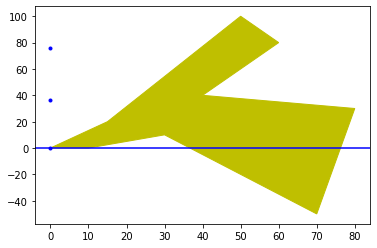

In [4]:
y_val = 0
points = polygon_intersect_y(p, y_val)
minmax = [points[0], points[-1]]  # The values are already sorted

ax = plt.gca()

ax.fill(*p.boundary.xy, color='y')
ax.axhline(y_val, color='b')

ax.plot([y_val,] * len(points), points, 'b.')
#ax.plot([y_val, ] * 2, minmax, 'ro', ms=10)
